In [53]:
import pandas as pd
import numpy as np
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import json
import pandas_profiling
from datetime import timedelta

In [2]:
#read in data into a DF and set the index
df = pd.read_json('logins.json')
df.set_index('login_time', inplace=True)
df = df.sort_index()
#df.head()

# Exploratory Analysis

In [3]:
#find daily average over 15-minute intervals
df['count'] = 1
minute15 = df.resample('15T').apply(sum)

In [4]:
minute15.head()

count
login_time                
1970-01-01 20:00:00      2
1970-01-01 20:15:00      6
1970-01-01 20:30:00      9
1970-01-01 20:45:00      7
1970-01-01 21:00:00      1

Text(0.5, 1.0, 'Average Logins for Each Hour of the Day')

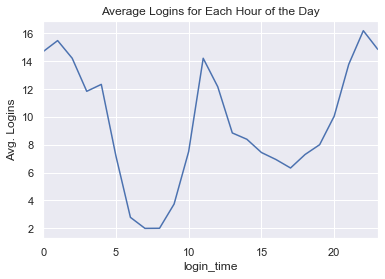

In [5]:
#Find most/least popular times of day and plot
minute15.groupby(minute15.index.hour).mean()['count'].plot()
plt.ylabel('Avg. Logins')
plt.title('Average Logins for Each Hour of the Day')

It appears as though the most popular time for logging in occurs between 10PM and 1AM. Another popular login time is around 11AM. On average, not many people login from 6AM to 8AM.

In [6]:
#average daily count
minute15 = minute15.resample('D').mean()

In [7]:
#add in day and month column
minute15['day'] = minute15.index.day_name()
minute15['month'] = minute15.index.month_name()
minute15.head()

count       day    month
login_time                             
1970-01-01  7.000000  Thursday  January
1970-01-02  7.093750    Friday  January
1970-01-03  8.260417  Saturday  January
1970-01-04  8.208333    Sunday  January
1970-01-05  4.781250    Monday  January

Text(0, 0.5, 'Average Number of Logins (Every 15 Minutes)')

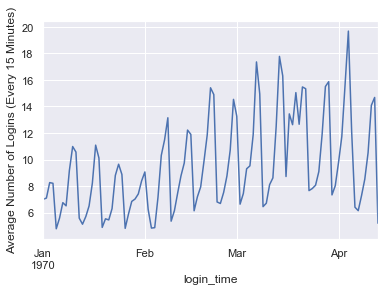

In [8]:
#display plot of aggregated daily logins over time
minute15['count'].plot()
plt.ylabel('Average Number of Logins (Every 15 Minutes)')

Since the plot above is filtered by day of the week, we can see that certain days of the week cause the number of logins to increase. Also, the graph seems to generally trend upward over the four months. Let's explore which days are the most/least popular.

In [9]:
#find average logins for each day of the week
for day in set(minute15['day'].values):
    print(day,'------------>', np.mean(minute15[minute15['day'] == day]))

Sunday ------------> count    12.615972
dtype: float64
Tuesday ------------> count    6.895833
dtype: float64
Thursday ------------> count    8.694444
dtype: float64
Wednesday ------------> count    7.692708
dtype: float64
Monday ------------> count    6.199269
dtype: float64
Saturday ------------> count    13.45625
dtype: float64
Friday ------------> count    10.561111
dtype: float64


We can see that Saturday and Sunday average the most logins per 15 minutes, with 13.46 and 12.62 logins, respectively. This is represented by the peaks in the above chart. There is a steep dropoff (valleys in the above chart) when going from Sunday to Monday, as the average Monday logins per 15 minutes are the lowest of any day, at 6.12. 

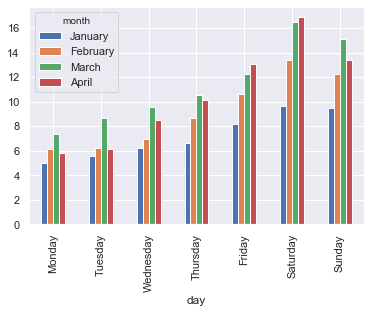

In [10]:
#order plot by month and by day for cleaner visualization
months = ['January', 'February', 'March', 'April']
order = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
m1 = minute15.reset_index().pivot_table(index='day',columns='month',values='count',aggfunc='mean')
m1 = m1.loc[order]
m1 = m1.loc[:,months]
m1.plot(kind='bar')

We can see from the visualization above that as the week progresses, logins generally increase (if we start with Monday). Logins peak on Saturdays, and decrease slightly on Sundays. March and April were the two most login-heavy months.

# Experiment and Metrics Design

The    neighboring     cities    of    Gotham    and    Metropolis    have     complementary     circadian     rhythms:     on  weekdays,    Ultimate    Gotham     is    most     active    at    night,    and    Ultimate    Metropolis     is    most    active  during     the    day.    On    weekends,     there     is     reasonable    activity     in    both     cities.

However,    a     toll    bridge,     with     a     two-way     toll,    between     the     two     cities     causes    driver    partners     to     tend  to    be    exclusive     to    each     city.     The     Ultimate    managers    of     city    operations     for     the     two     cities    have  proposed    an    experiment     to     encourage    driver    partners     to    be    available     in    both     cities,    by  reimbursing    all     toll     costs.

1. What    would     you     choose     as     the     key    measure    of     success    of     this    experiment     in  encouraging    driver     partners     to     serve    both     cities,    and    why    would     you     choose     this    metric?

2. Describe    a    practical     experiment     you    would    design     to     compare     the    effectiveness    of     the  proposed     change     in     relation     to     the     key    measure    of     success.    Please    provide    details     on:   
    - how     you    will     implement     the    experiment

    - what     statistical     test(s)     you    will     conduct     to     verify     the     significance    of     the  observation  

    - how     you    would     interpret     the     results    and    provide     recommendations     to     the     city  operations     team    along    with    any     caveats.

1) The measure of success we will choose is total toll cost reimbursements. We will use this measure because it allows us to determine whether or not drivers are leaving their respective cities, and how often

2) An experiment we can set up to compare the effectiveness of the proposed change in relation to toll cost reimbursements is a comparison of two means: Weekday Gotham Reimbursements vs Weeknight Gotham Reimbursements. Since the people of Gotham are more likely to need drivers at night, and people of Metropolis are more likely to need drivers during the day, we can see if the drivers of Gotham are leaving during the day to seek business in Metropolis now that the toll reimbursement rule has been implemented. If we find that these two means are significantlly different, we can say that we have evidence that the change is effective.

We implement the experiment by setting up the reimbursement data for Gotham drivers into two groups: Weekday Reimbursements (Treatment Group) and Weeknight Reimbursements (Control Group). We take note of the difference in mean reimbursements for both groups, and call the mean $\mu$. Next, we use a simulator to re-randomize the treatment and control groups into two new, randomized groups. We measure the difference in means between the randomized groups, and repeat this process 1000 times, and build a histogram to see where $\mu$ lies in comparison to randomized means. If $\mu$ lies outside of the data within the 2.5th - 97.5th percentiles, we can say that we have strong evidence to support that the reimbursement plan is effective.

If the results indicate that the toll reimbursement plan is working, we would communicate this to the city operations team, and recommend that they continue to reimburse drivers for seeking business in the neighboring city. If the results are not significant, we would recommend a different course of action than the reimbursement, such as additionals incentives for drivers going to the neighboring city.

# Predictive Modeling

1. Perform    any     cleaning,     exploratory    analysis,    and/or     visualizations     to    use     the    provided  data     for     this    analysis     (a     few     sentences/plots    describing     your    approach    will     suffice).    What  fraction     of     the    observed     users    were     retained?

In [17]:
with open('ultimate_data_challenge.json') as f:
    d = json.load(f)

In [23]:
ultimate = pd.DataFrame.from_records(d)
ultimate.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

In [21]:
ultimate.profile_report()

In [31]:
#Fill in missing values using mean of columns
ultimate = ultimate.fillna(ultimate.mean())

In [34]:
ultimate.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

In [35]:
# Change last_trip_date and signup_date to datetime objects
ultimate['last_trip_date'] = pd.to_datetime(ultimate['last_trip_date'])
ultimate['signup_date'] = pd.to_datetime(ultimate['signup_date'])

In [36]:
# Drop duplicate rows
ultimate = ultimate.drop_duplicates()

In [37]:
ultimate.profile_report()

In [43]:
ultimate.sort_values('last_trip_date', ascending=False).head()

city  trips_in_first_30_days signup_date  \
26276  King's Landing                       3  2014-01-02   
9008       Winterfell                       7  2014-01-06   
6776   King's Landing                       1  2014-01-25   
29022      Winterfell                      10  2014-01-30   
3824       Winterfell                       1  2014-01-06   

       avg_rating_of_driver  avg_surge last_trip_date   phone  surge_pct  \
26276                   5.0       1.06     2014-07-01  iPhone       25.0   
9008                    4.9       1.12     2014-07-01  iPhone       13.6   
6776                    5.0       1.16     2014-07-01  iPhone       26.3   
29022                   4.5       1.00     2014-07-01  iPhone        0.0   
3824                    5.0       1.02     2014-07-01  iPhone        8.3   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  
26276                False         75.0      1.83                   5.0  
9008                  True         68.9      4.48                   4.8  
6776                 False         47.4      2.64                   4.5  
29022                 True         68.0      3.65                   4.3  
3824                 False         58.3      2.86                   4.8

We can see tht the last trip date in the dataset is 07-01-2014. We now will calculate what percentage of users took a trip in the 30 days leading up to 07-01-2014.

In [49]:
# First fin total length of data set
total = len(ultimate)

# Now find total number of users that used app in last 30 days, or since 06-02-2014
retained = len(ultimate[ultimate['last_trip_date'] > '2014-06-02'])

# Find the percentage of users that were retained
print(retained/total)

0.36209793566970716


We can see that approximately 36.2% of users were "retained".

2. Build    a    predictive     model     to     help    Ultimate    determine    whether    or    not    a    user    will    be    active  in     their    6th    month     on     the     system.    Discuss    why     you     chose     your    approach,    what  alternatives     you     considered,     and    any     concerns     you    have.    How     valid     is     your    model?  Include    any     key     indicators    of     model    performance. 

In [51]:
# get dataset of users who are definitively active in their 6th month
ultimate.head()


city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

In [69]:
# This filtering gives us users who are active in their sixth month
# We use 151 days as our time period to determine use in a user's 6th month
active6 = ultimate[(ultimate['signup_date'] < '2014-02-01') & (ultimate['last_trip_date'] >= (ultimate['signup_date'] + timedelta(days=151)))]
# Label these users
active6['status'] = 'active'


# This filtering gives us users who are almost certainly inactive in their sixth month
# We tweak the time delta to ensure we are getting users who have clearly not taken a trip
# anywhere near their 151st day in the system
inactive6 = ultimate[(ultimate['signup_date'] < '2014-02-01') & (ultimate['last_trip_date'] < (ultimate['signup_date'] + timedelta(days=130)))]
# Label these users
inactive6['status'] = 'inactive'

In [70]:
inactive6.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
1     Astapor                       0  2014-01-29              5.000000   
2     Astapor                       3  2014-01-06              4.300000   
4  Winterfell                      14  2014-01-27              4.400000   
6     Astapor                       1  2014-01-24              4.601559   
7  Winterfell                       2  2014-01-28              5.000000   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
4       1.19     2014-03-15  Android       11.8                False   
6       1.00     2014-01-25  Android        0.0                False   
7       1.00     2014-01-29   iPhone        0.0                False   

   weekday_pct  avg_dist  avg_rating_by_driver    status  
1         50.0      8.26                   5.0  inactive  
2        100.0      0.77                   5.0  inactive  
4         82.4      3.13                   4.9  inactive  
6        100.0      3.95                   4.0  inactive  
7        100.0      2.04                   5.0  inactive

In [87]:
predDf = active6.append(inactive6)

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [133]:
feature_cols = ['city', 'trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge','phone','surge_pct','ultimate_black_user','weekday_pct','avg_dist','avg_rating_by_driver']
X = predDf[feature_cols] # Features
y = predDf.status # Target variable

# Split the data into a training and test set
Xrf, Xtestrf, yrf, ytestrf = train_test_split(X,y,test_size=0.25,random_state=51)

# Now we want to predict status
# Setup table in way to do so:
target_col = ['status']
cat_cols = ['city','phone','ultimate_black_user']
num_cols= ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge','surge_pct',
          'weekday_pct','avg_dist','avg_rating_by_driver']
other_col= ['signup_date','last_trip_date']

# Create label encoders for categorical variables and split the data set
# to train & test, further split the train data set to Train and Validate

#create label encoders for categorical features
for var in cat_cols:
    number = LabelEncoder()
    Xrf[var] = number.fit_transform(Xrf[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    Xtestrf[var] = number.fit_transform(Xtestrf[var].astype('str'))

In [137]:
clf = RandomForestClassifier()
# Fit the model on the trainng data.
clf.fit(Xrf, yrf)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestrf), ytestrf))

0.7941736481340441


In [138]:
y_pred=clf.predict(Xtestrf)

In [139]:
from sklearn import metrics
from sklearn.metrics import classification_report
cnf_matrix = metrics.confusion_matrix(ytestrf, y_pred)
cnf_matrix

array([[1975, 1067],
       [1095, 6367]], dtype=int64)

In [140]:
print(classification_report(ytestrf, y_pred, target_names=['active','inactive']))

              precision    recall  f1-score   support

      active       0.64      0.65      0.65      3042
    inactive       0.86      0.85      0.85      7462

    accuracy                           0.79     10504
   macro avg       0.75      0.75      0.75     10504
weighted avg       0.79      0.79      0.79     10504



In [141]:
print("Accuracy:",metrics.accuracy_score(ytestrf, y_pred))
print("Precision:",metrics.precision_score(ytestrf, y_pred,pos_label='active'))
print("Recall:",metrics.recall_score(ytestrf, y_pred,pos_label='active'))

Accuracy: 0.7941736481340441
Precision: 0.6433224755700325
Recall: 0.6492439184746877


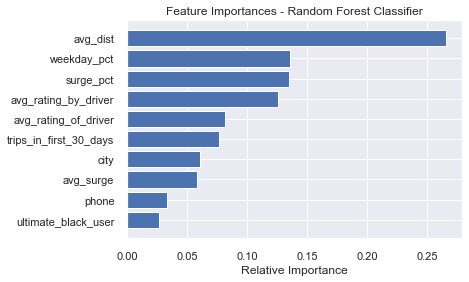

In [148]:
features = Xrf.columns
importances = clf.feature_importances_
indices = np.argsort(-importances)[::-1]
plt.title('Feature Importances - Random Forest Classifier')
plt.barh(range(len(indices[:10])), importances[indices[:10]], color='b', align='center')
plt.yticks(range(len(indices[:10])), [features[i] for i in indices[:10]])
plt.xlabel('Relative Importance')
plt.show()

The approach we took is finding users who are active in their 6th month in the system, and finding users who are (with reasonable certainty) inactive. We label each user as such and use these labels as our target variable. The other variables, as shown in the chart above, are our predictors. We break down our newly-labeled dataset into train/test, and build a random forest classifier using the training data. We find that our model predicts the test data with 79.4% accuracy.

The reason we took the approach of labeling our data in this manner is that we could clearly label someone who is in their 6th month on the system as 'active' with our definition, and the data allowed us to reasonably assume a user was inactive by our definition. This allowed us to state our assumption, and build a model given the assumption. One concern with our approach might be that we left some users out of our newly labeled data set since it was difficult to define the activity of these particular users. For example, by our definition, a user who wasn't technically active in his/her sixth month according to our data may have actually been active, but the dates in our data didn't reach far enough to accurately label the user. Another approach may have been to label users active in their 5th month in the system as 'active' and all others as 'inactive' in order to have no loss of data, though there are clearly some drawbacks of using this approach since we are going for a month 6 model.

According to our model, the most important predictor of users being active in their 6th month is avg_dist, as it has over twice the importance as the next highest feature. The average distance a user takes in his/her first 30 days using our system is clearly important, and we would be wise to leverage this information. We might consider incentives for people who have lower avg_dist, such as occasional free or discounted rides if they continue using the service. This would likely help keep users who have lower avg_dist interested, and imporve long-term retention for these users.